### Test different thresholds of IPC levels for FewsNet and Global IPC
For the anticipatory action framework, we want to define the trigger mechanism based on data. One of the possible data sources are IPC levels. Based on the historical analysis of FewsNet and Global IPC, and conversations with partners, different triggers were tested. This notebook provides a subset of tested triggers and the code to easily test any triggers of interest.    

IPC trigger design as of 08-10-2020:   
EITHER: At least 20% population of one or more ADMIN1 regions projected at IPC4+ in 3 months   
OR:    
At least 30% of ADMIN1 population projected at IPC3+ AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ in 3 months compared to current state

Main experimenting was done with FewsNet due to more historical data. The most relevant triggers were also analysed for Global IPC

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os
import sys
path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
print(path_mod)
sys.path.append(path_mod)
# from indicators.drought.iri_rainfallforecast import get_iri_data,statistics_alldates
# from indicators.drought.icpac_rainfallforecast import get_icpac_data
# from indicators.drought.nmme_rainfallforecast import get_nmme_data
from indicators.food_insecurity.config import Config
from indicators.food_insecurity.ipc_definemetrics import define_trigger_percentage, define_trigger_increase, define_trigger_increase_rel
from utils_general.plotting import plot_boundaries_binary

/Users/tinkavalentijn/Documents/CHD/AAFI/pa-anticipatory-action/


In [3]:
country="ethiopia"
#suffix of filenames
suffix=""
config=Config()
parameters = config.parameters(country)
country_folder = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
fewsnet_dir = os.path.join(country_folder, config.DATA_DIR, config.FEWSWORLDPOP_PROCESSED_DIR)

### FewsNet

### Explore thresholds on admin1 level

In [4]:
admin_level=1
fewsnet_filename = config.FEWSWORLDPOP_PROCESSED_FILENAME.format(country=country,admin_level=admin_level,suffix=suffix)
adm1_bound_path= os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])

In [5]:
df_fadm=pd.read_csv(os.path.join(fewsnet_dir,fewsnet_filename))
df_fadm["date"]=pd.to_datetime(df_fadm["date"])
df_fadm["year"]=df_fadm["date"].dt.year
df_fadm["month"]=df_fadm["date"].dt.month

In [6]:
df_fadm.tail()

,ADMIN0,ADMIN1,date,CS_1,CS_2,CS_3,CS_4,CS_99,ML1_1,ML1_2,...,ML2_3p,perc_ML2_3p,ML2_4p,perc_ML2_4p,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p,year,month
511,Ethiopia,Benishangul Gumz,2020-10-01,1.148038e+06,1.172883e+05,0.00000,0.0,NaN,1.148038e+06,1.172883e+05,...,0.000000e+00,0.000000,0.0,0.0,1.265326e+06,100.000000,0.000000,0.000000,2020,10
512,Ethiopia,Afar,2020-10-01,1.613871e+04,1.417134e+06,612370.21875,0.0,NaN,1.613871e+04,1.114601e+06,...,1.761135e+06,86.092025,0.0,0.0,2.845075e+05,13.907975,56.156680,14.789126,2020,10
513,Ethiopia,Addis Ababa,2020-10-01,3.938355e+06,0.000000e+00,0.00000,0.0,NaN,3.938355e+06,0.000000e+00,...,0.000000e+00,0.000000,0.0,0.0,3.938355e+06,100.000000,0.000000,0.000000,2020,10
514,Ethiopia,Tigray,2020-10-01,6.210399e+06,3.347936e+05,0.00000,0.0,NaN,4.480197e+06,2.064996e+06,...,8.561870e+05,13.081159,0.0,0.0,5.689005e+06,86.918841,13.081159,0.000000,2020,10
515,Ethiopia,Amhara,2020-10-01,2.304478e+07,1.651785e+06,0.00000,0.0,NaN,2.078818e+07,3.908391e+06,...,2.575729e+06,10.429500,0.0,0.0,2.212084e+07,89.570500,10.429500,0.000000,2020,10


TODO: The updates of 2020-09-01 and 2020-08-01 don't include any CS data! For the analysis CS data of 2020-06 should be used. Previously just added that data to the raw fewsnet data files, but would prefer to add it here

In [7]:
#TODO: replace CS values for 2020-08 and 2020-09 with those of 2020-06
CS_cols=[c for c in df_fadm.columns if "CS" in c]
# date_replace="2020-06-01"
# blub=df_fadm.copy()
for d in ["2020-08-01","2020-09-01"]:
    for i in df_fadm.ADMIN1.unique():
        df_fadm.loc[((df_fadm.date==d)&(df_fadm.ADMIN1==i)),CS_cols]=np.nan
        
#         print(i)
# #         print(df_fadm.loc[(df_fadm.date==date_replace)&(df_fadm.ADMIN1==i),CS_cols])
# #         df_fadm.loc[((df_fadm.date==d)&(df_fadm.ADMIN1==i)),CS_cols]=df_fadm.loc[((df_fadm.date==date_replace)&(df_fadm.ADMIN1==i)),CS_cols]
#         print(blub.loc[((blub.date==date_replace)&(blub.ADMIN1==i)),CS_cols])
# #         print(len([blub.loc[((blub.date==date_replace)&(blub.ADMIN1==i)),CS_cols]]))
# #         print(len(blub.loc[((blub.date==d)&(blub.ADMIN1==i)),CS_cols]))
#         blub.loc[((blub.date==d)&(blub.ADMIN1==i)),CS_cols] = blub.loc[((blub.date==d)&(blub.ADMIN1==i)),CS_cols].update(blub.loc[((blub.date==date_replace)&(blub.ADMIN1==i)),CS_cols])
# #         blub.loc[((blub.date==d)&(blub.ADMIN1==i)),CS_cols]=blub.loc[((blub.date==date_replace)&(blub.ADMIN1==i)),CS_cols].values #[blub.loc[((blub.date==date_replace)&(blub.ADMIN1==i)),CS_cols]]
#         print(blub.loc[((blub.date==d)&(blub.ADMIN1==i)),CS_cols])
        

In [8]:
#never been or forecasted to be IPC 5
print("CS 5",df_fadm.CS_5.unique())
print("ML1 5", df_fadm.ML1_5.unique())

CS 5 [ 0. nan]
ML1 5 [0.]


In [9]:
#most current numbers
df_fadm.loc[df_fadm.date==df_fadm.date.max(),["date",f"ADMIN{admin_level}","perc_CS_3p","perc_CS_4","perc_ML1_3p","perc_ML1_4","perc_ML2_3p","perc_ML2_4"]]

,date,ADMIN1,perc_CS_3p,perc_CS_4,perc_ML1_3p,perc_ML1_4,perc_ML2_3p,perc_ML2_4
504,2020-10-01,Somali,61.641539,0.0,66.763138,0.0,66.763138,0.0
505,2020-10-01,Sidama,0.000000,0.0,0.000000,0.0,0.000000,0.0
506,2020-10-01,SNNP,0.000000,0.0,2.380666,0.0,39.486623,0.0
507,2020-10-01,Oromia,3.239858,0.0,8.624395,0.0,19.858628,0.0
508,2020-10-01,Harari,0.000000,0.0,0.000000,0.0,0.000000,0.0
509,2020-10-01,Gambela,0.000000,0.0,0.000000,0.0,0.000000,0.0
510,2020-10-01,Dire Dawa,0.000000,0.0,0.000000,0.0,0.000000,0.0
511,2020-10-01,Benishangul Gumz,0.000000,0.0,0.000000,0.0,0.000000,0.0
512,2020-10-01,Afar,29.935345,0.0,44.724472,0.0,86.092025,0.0
513,2020-10-01,Addis Ababa,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [10]:
#get yes/no for different thresholds, i.e. column value for row will be 1 if threshold is met and 0 if it isnt
df_fadm["trigger_CS_3_20"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"CS",3,20),axis=1)
df_fadm["trigger_CS_3_40"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"CS",3,40),axis=1)
df_fadm["trigger_CS_4_2"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"CS",4,2.5),axis=1)
df_fadm["trigger_CS_4_20"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"CS",4,20),axis=1)
df_fadm["trigger_CS_4_10"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"CS",4,10),axis=1)
df_fadm["trigger_CS_4_1"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"CS",4,0.1),axis=1)
df_fadm["trigger_ML1_3_5"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML1",3,5),axis=1)
df_fadm["trigger_ML1_4_2"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML1",4,2.5),axis=1)
df_fadm["trigger_ML1_4_20"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML1",4,20),axis=1)
df_fadm["trigger_ML1_3_20"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML1",3,20),axis=1)
df_fadm["trigger_ML1_3_30"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML1",3,30),axis=1)
df_fadm["trigger_ML1_3_5ir"]=df_fadm.apply(lambda x: define_trigger_increase_rel(x,3,5),axis=1)
df_fadm["trigger_ML1_3_40ir"]=df_fadm.apply(lambda x: define_trigger_increase_rel(x,3,40),axis=1)
df_fadm["trigger_ML1_3_70ir"]=df_fadm.apply(lambda x: define_trigger_increase_rel(x,3,70),axis=1)
df_fadm["trigger_ML1_3_5i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML1",3,5),axis=1)
df_fadm["trigger_ML1_3_10i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML1",3,10),axis=1)
df_fadm["trigger_ML1_3_20i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML1",3,20),axis=1)
df_fadm["trigger_ML1_3_30i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML1",3,30),axis=1)
df_fadm["trigger_ML1_3_40i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML1",3,40),axis=1)
df_fadm["trigger_ML1_3_50i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML1",3,50),axis=1)
df_fadm["trigger_ML1_3_70i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML1",3,70),axis=1)
df_fadm["trigger_ML2_4_20"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML2",4,20),axis=1)
df_fadm["trigger_ML2_3_30"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML2",3,30),axis=1)
df_fadm["trigger_ML2_3_5i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML2",3,5),axis=1)

In [11]:
#initialize dict with all the analyses
dict_fan={}

In [12]:
#currently (Oct 2020) selected trigger
df_an1=df_fadm.loc[(df_fadm["trigger_ML1_4_20"]==1) | ((df_fadm["trigger_ML1_3_30"]==1) & (df_fadm["trigger_ML1_3_5i"]==1))]
display(df_an1.groupby(['year', 'month'], as_index=False)[f"ADMIN{admin_level}",'perc_ML1_4p','perc_CS_3p','perc_ML1_3p','perc_inc_ML1_3p'].agg(lambda x: list(x)))
dict_fan["an1"]={"df":df_an1,"trig_cols":["ML1_3p","CS_3p","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)"}

,year,month,ADMIN1,perc_ML1_4p,perc_CS_3p,perc_ML1_3p,perc_inc_ML1_3p
0,2009,7,"[Somali, Gambela]","[58.838478590938884, 0.02042319105364591]","[99.92630206112149, 0.35967690558953597]","[99.92630205392872, 60.86321138942488]","[-7.192753059825918e-09, 60.503534483835345]"
1,2010,1,"[Tigray, Somali, Harari, Dire Dawa, Gambela, A...","[15.498742872540445, 20.9428185393442, 0.0, 0....","[17.812106920283046, 66.21220082737858, 0.0, 0...","[47.74658231203844, 99.94487702875485, 100.0, ...","[29.9344753917554, 33.732676201376265, 100.0, ..."
2,2010,10,[Somali],[0.0],[3.847626394095229],[29.90268555469125],[26.055059160596016]
3,2011,4,[Somali],[42.04157234227331],[99.70272903008734],[99.72828794624691],[0.025558916159553743]
4,2011,7,[Somali],[35.169034032132174],[99.88700508785186],[99.88700510867235],[2.0820479562644323e-08]
5,2012,4,[Afar],[0.0],[25.907795306541747],[46.83084649974166],[20.923051193199925]
6,2013,1,"[Somali, Sidama, SNNP]","[0.0, 0.0, 0.0]","[27.985839782976733, 0.0, 8.652726675156972e-05]","[53.664306949241286, 45.78467852807977, 35.326...","[25.678467166264568, 45.78467852807977, 35.326..."
7,2016,2,[Amhara],[2.511534687823407],[24.027335589190763],[29.640725645949203],[5.613390056758436]
8,2017,6,[Somali],[23.77530894791369],[61.220325449332655],[61.35341463827103],[0.13308918893838495]
9,2017,10,[Somali],[21.660499771703197],[47.20013319510721],[66.04164880153716],[18.84151560642996]


In [13]:
#Analysis 2: At least 20% of ADMIN1 population at IPC4+ in ML1
df_an2 = df_fadm.loc[(df_fadm["trigger_ML1_4_20"]==1)]
display(df_an2.groupby(['year', 'month'], as_index=False)[f"ADMIN{admin_level}",'perc_ML1_4'].agg(lambda x: list(x)))
dict_fan["an2"]={"df":df_an2,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1"}

,year,month,ADMIN1,perc_ML1_4
0,2009,7,[Somali],[58.838478590938884]
1,2010,1,"[Somali, Gambela, Afar]","[20.9428185393442, 60.570279844055996, 31.0068..."
2,2011,4,[Somali],[42.04157234227331]
3,2011,7,[Somali],[35.169034032132174]
4,2017,6,[Somali],[23.77530894791369]
5,2017,10,[Somali],[21.660499771703197]


In [14]:
#Analysis 3: At least 30% of ADMIN1 population projected to be at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
df_an3 = df_fadm.loc[(df_fadm["trigger_ML1_3_30"]==1) & (df_fadm["trigger_ML1_3_5i"]==1)]
display(df_an3.groupby(['year', 'month'], as_index=False)[f"ADMIN{admin_level}",'perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_fan["an3"]={"df":df_an3,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

,year,month,ADMIN1,perc_CS_3p,perc_ML1_3p
0,2009,7,[Gambela],[0.35967690558953597],[60.86321138942488]
1,2010,1,"[Tigray, Somali, Harari, Dire Dawa, Afar]","[17.812106920283046, 66.21220082737858, 0.0, 0...","[47.74658231203844, 99.94487702875485, 100.0, ..."
2,2010,10,[Somali],[3.847626394095229],[29.90268555469125]
3,2012,4,[Afar],[25.907795306541747],[46.83084649974166]
4,2013,1,"[Somali, Sidama, SNNP]","[27.985839782976733, 0.0, 8.652726675156972e-05]","[53.664306949241286, 45.78467852807977, 35.326..."
5,2016,2,[Amhara],[24.027335589190763],[29.640725645949203]
6,2017,10,[Somali],[47.20013319510721],[66.04164880153716]
7,2019,2,[Somali],[59.03487765736936],[74.20183695570523]
8,2019,10,[Afar],[32.47905386920189],[38.909524762858936]
9,2020,6,"[Somali, Harari, Afar]","[48.16132808167792, 0.0, 33.3545202172772]","[71.82254138855203, 100.0, 68.03548622248769]"


In [15]:
# #Some previously tested triggers
# #More triggers were analysed, the ones below substitute a subset which shows the variety of investigated triggers
# #Analysis 4: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)
# df_an4 = df_fadm.loc[(df_fadm['trigger_CS_3_20']==1)&(df_fadm['trigger_ML1_4_2']==1)]
# dict_fan["an4"]={"df":df_an4,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)"}

# #Analysis 5: 20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% RELATIVE increase in IPC3+ (ML1))
# df_an5 = df_fadm.loc[(df_fadm['trigger_CS_3_20']==1)&((df_fadm['trigger_ML1_4_2']==1)| (df_fadm['trigger_ML1_3_5ir'] == 1))]
# dict_fan["an5"]={"df":df_an5,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% RELATIVE increase in IPC3+ (ML1))"}

# #Analysis 6: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% RELATIVE increase in IPC3+ (ML1)
# df_an6 = df_fadm.loc[(df_fadm['trigger_CS_3_20']==1)&(df_fadm['trigger_CS_4_2']==1) & (df_fadm['trigger_ML1_3_5ir'] == 1)]
# dict_fan["an6"]={"df":df_an6,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% RELATIVE increase in IPC3+ (ML1)"}

# #Analysis 7: IPC4 at 20% (current situation)
# df_an7 = df_fadm.loc[df_fadm['trigger_CS_4_20']==1]
# dict_fan["an7"]={"df":df_an7,"trig_cols":["CS_4"],"desc":"IPC4 at 20% (current situation)"}

# #Analysis 8: 5% increase in IPC3+ (ML1)
# df_an8 = df_fadm.loc[(df_fadm['trigger_ML1_3_5i']==1)]
# dict_fan["an8"]={"df":df_an8,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"5% increase in number of people in IPC3+ (ML1)"}

# #Analysis 9: At least 20% of ADMIN1 population projected to be at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
# df_an9 = df_fadm.loc[(df_fadm["trigger_ML1_3_20"]==1) & (df_fadm["trigger_ML1_3_5i"]==1)]
# dict_fan["an9"]={"df":df_an9,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

# #Analysis 10: At least 20% of population projected in ML2 in IPC4+
# df_an10=df_fadm.loc[(df_fadm['trigger_ML2_4_20']==1)]
# dict_fan["an10"]={"df":df_an10,"trig_cols":["ML2_4"],"desc":"20% of population projected in ML2 in IPC4+"}

#Analysis 11: At least 20% of population projected in ML2 in IPC4+ OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)
df_an11=df_fadm.loc[(df_fadm["trigger_ML2_4_20"]) | ((df_fadm["trigger_ML2_3_30"]==1)&(df_fadm["trigger_ML2_3_5i"]==1))]
display(df_an11.groupby(['year', 'month'], as_index=False)[f"ADMIN{admin_level}",'perc_CS_3p','perc_ML2_3p','perc_ML2_4'].agg(lambda x: list(x)))
dict_fan["an11"]={"df":df_an11,"trig_cols":["ML2_3","ML2_4"],"desc":"20% in ML2 in IPC4 OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)"}

,year,month,ADMIN1,perc_CS_3p,perc_ML2_3p,perc_ML2_4
0,2009,7,[Somali],[99.92630206112149],[67.81206478239946],[43.747226849781626]
1,2009,10,[Afar],[68.21343890758456],[97.56864808679993],[0.0]
2,2010,1,"[Oromia, Tigray, Somali, Sidama, Harari, SNNP,...","[2.904801010100862, 17.812106920283046, 66.212...","[30.23100218626925, 66.70734243174189, 99.9160...","[10.422713581902935, 32.16184434509727, 11.071..."
3,2010,4,"[Oromia, Benishangul Gumz, Amhara]","[21.295342252916495, 0.0, 28.52037851597407]","[32.324721153728945, 30.081886670780932, 37.72...","[2.966421421410248, 0.0, 3.583951322309754]"
4,2010,7,[Somali],[3.8869541908595777],[66.1910793307612],[0.00017197707288448284]
5,2010,10,"[Sidama, SNNP]","[19.02399357621852, 18.854716907234614]","[51.62987354532428, 30.9883265933908]","[0.0, 0.0]"
6,2011,1,"[Somali, Afar]","[74.24639368908862, 21.293813164698523]","[78.3865011453275, 74.2291722017918]","[42.041568249590895, 0.0]"
7,2011,4,"[Somali, Sidama, SNNP, Harari]","[99.70272903008734, 28.654669365962828, 52.021...","[99.80378461781748, 56.99944657871885, 58.1668...","[42.1032406434231, 0.0, 0.0, 0.0]"
8,2011,10,"[Somali, SNNP, Gambela, Afar]","[66.28346511553, 7.478802140842782, 0.02157730...","[66.20284738103193, 50.06092891164962, 35.1395...","[31.746406709388108, 2.264853160575614, 0.0, 0.0]"
9,2012,1,"[Harari, SNNP, Afar]","[0.0, 6.771270404801215, 26.001132916882938]","[76.12373166270505, 50.353393296031406, 32.788...","[0.0, 0.014392642550843425, 0.0]"


In [16]:
#plot all analysis in nicer format
for k in dict_fan.keys():
    d=dict_fan[k]["desc"]
    num_k=k.replace("an","")
    print(f"Analysis {num_k}: FewsNet, {d}")
    df=dict_fan[k]["df"]
    df_grouped=df.groupby(['date','year', 'month'], as_index=False)[f"ADMIN{admin_level}"].agg(lambda x: list(x))
    dict_fan[k]["df_group"]=df_grouped
    df_grouped[f"Regions triggered"]=[', '.join(map(str, l)) for l in df_grouped[f"ADMIN{admin_level}"]]
    df_grouped["Trigger description"]=d
    df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
    display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))

Analysis 1: FewsNet, At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)


Regions triggered
year month                                                  
2009 7                                       Somali, Gambela
2010 1      Tigray, Somali, Harari, Dire Dawa, Gambela, Afar
     10                                               Somali
2011 4                                                Somali
     7                                                Somali
2012 4                                                  Afar
2013 1                                  Somali, Sidama, SNNP
2016 2                                                Amhara
2017 6                                                Somali
     10                                               Somali
2019 2                                                Somali
     10                                                 Afar
2020 6                                  Somali, Harari, Afar
     10                                         Somali, Afar

Analysis 2: FewsNet, At least 20% of ADMIN1 population in IPC4+ at ML1


Regions triggered
year month                       
2009 7                     Somali
2010 1      Somali, Gambela, Afar
2011 4                     Somali
     7                     Somali
2017 6                     Somali
     10                    Somali

Analysis 3: FewsNet, At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months


Regions triggered
year month                                         
2009 7                                      Gambela
2010 1      Tigray, Somali, Harari, Dire Dawa, Afar
     10                                      Somali
2012 4                                         Afar
2013 1                         Somali, Sidama, SNNP
2016 2                                       Amhara
2017 10                                      Somali
2019 2                                       Somali
     10                                        Afar
2020 6                         Somali, Harari, Afar
     10                                Somali, Afar

Analysis 11: FewsNet, 20% in ML2 in IPC4 OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)


Regions triggered
year month                                                   
2009 7                                                 Somali
     10                                                  Afar
2010 1      Oromia, Tigray, Somali, Sidama, Harari, SNNP, ...
     4                       Oromia, Benishangul Gumz, Amhara
     7                                                 Somali
     10                                          Sidama, SNNP
2011 1                                           Somali, Afar
     4                           Somali, Sidama, SNNP, Harari
     10                           Somali, SNNP, Gambela, Afar
2012 1                                     Harari, SNNP, Afar
     4                                                 Harari
     10     Somali, Sidama, SNNP, Harari, Tigray, Dire Daw...
2013 1                   Tigray, Sidama, SNNP, Oromia, Amhara
2014 1                                                 Tigray
2015 10                                                Amhara
2016 2                                 Tigray, Oromia, Amhara
     10                                                Somali
2017 2                                Sidama, SNNP, Dire Dawa
     6                                                 Somali
     10                                                Somali
2018 2                                         Tigray, Somali
2020 2                                           Tigray, Afar
     6                                           Somali, Afar
     10                                    Somali, SNNP, Afar

### FewsNet admin1, plotting characteristics of the trigger
Chosen trigger: EITHER: At least 20% population of one or more ADMIN1 regions projected at IPC4+ in 3 months   
OR:    
At least 30% of ADMIN1 population projected at IPC3+ AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ in 3 months compared to current state

i.e. "an1"

In [17]:
df_fadm["threshold_reached"]= np.where((df_fadm["trigger_ML1_4_20"]==1) | ((df_fadm["trigger_ML1_3_30"]==1) & (df_fadm["trigger_ML1_3_5i"]==1)),1,0)
gdf=gpd.read_file(adm1_bound_path).rename(columns={parameters["shp_adm1c"]:config.ADMIN1_COL})
df_fadm=gdf[["ADMIN1","geometry"]].merge(df_fadm,how="right")

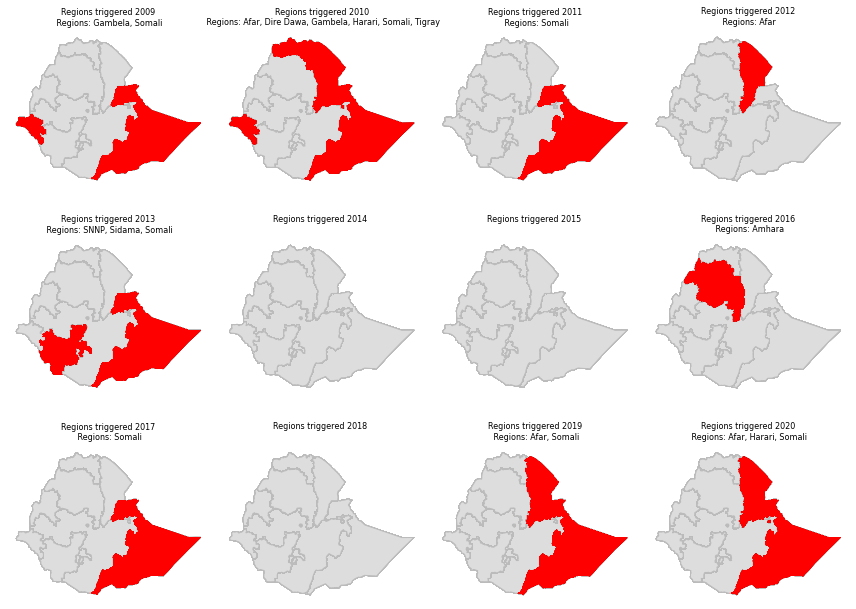

In [18]:
fig_boundbin=plot_boundaries_binary(df_fadm,"threshold_reached",subplot_col="year",subplot_str_col="year",region_col="ADMIN1",colp_num=4,only_show_reached=False,title_str="Regions triggered")

In [19]:
def plot_geo_var(df, sub_col, var_col, title=None, predef_bins=None, colp_num=2, cmap='YlOrRd'):
    """
    Plot the values of "col" for the dates present in df_trig
    If giving predef_bins then the data will be colored according to the bins, else a different colour will be assigned to each unique value in the data for each date
    df: DataFrame containing all the data of all regions
    df_trig: DataFrame containing the dates for which plots should be shown (generally those dates that the trigger is met)
    col: string with column to plot
    shape_path: relative path to the admin1 shapefile
    title: string with title of whole figure (so not the subplots)
    predef_bins: list with bin values
    """

    num_plots = len(df[sub_col].unique())
    rows = num_plots // colp_num
    rows += num_plots % colp_num
    position = range(1, num_plots + 1)

    if predef_bins is not None:
        scheme = None
        norm2 = mcolors.BoundaryNorm(boundaries=predef_bins, ncolors=256)
        legend_kwds=None
    else:
        scheme = "natural_breaks"
        norm2 = None
        legend_kwds = {'bbox_to_anchor': (1.6, 1)}

    figsize = (16, 10)
    fig = plt.figure(1, figsize=(16, 6 * rows))

    for i, c in enumerate(df[sub_col].unique()):
        ax = fig.add_subplot(rows, colp_num, position[i])

        df_sub = df[df[sub_col] == c]
        #if no predef bins, set unique color for each unique value
        if predef_bins is None:
            colors = len(df_sub[var_col].dropna().unique())
        #else colors will be determined by norm and cmap
        else:
            colors = None

        if df_sub[var_col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_sub[var_col].isnull().values.any():
            df_sub.plot(var_col, ax=ax, cmap=cmap, figsize=figsize, k=colors, norm=norm2, legend=True, scheme=scheme,
                        missing_kwds={"color": "lightgrey", "edgecolor": "red",
                                      "hatch": "///",
                                      "label": "Missing values"})
        else:
            df_sub.plot(var_col, ax=ax, cmap=cmap, figsize=figsize, k=colors, norm=norm2, legend=True, scheme=scheme)
        df.boundary.plot(linewidth=0.2, ax=ax)

        ax.axis("off")

        #prettify legend if using individual color for each value
        if predef_bins is None and not df_sub[var_col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text = upper
                lbl.set_text(new_text)

        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
    if title:
        fig.suptitle(title, fontsize=14, y=0.92)
#     fig.tight_layout()

    return fig

In [20]:
#all dates that trigger is met in at least one region (but include all regions on that date)
df_fadm_trig=df_fadm[df_fadm.date.isin(dict_fan["an1"]["df"].date.unique())]

In [21]:
#end value is not included, so set one higher than max value of last bin
bins=np.arange(0,101,10)

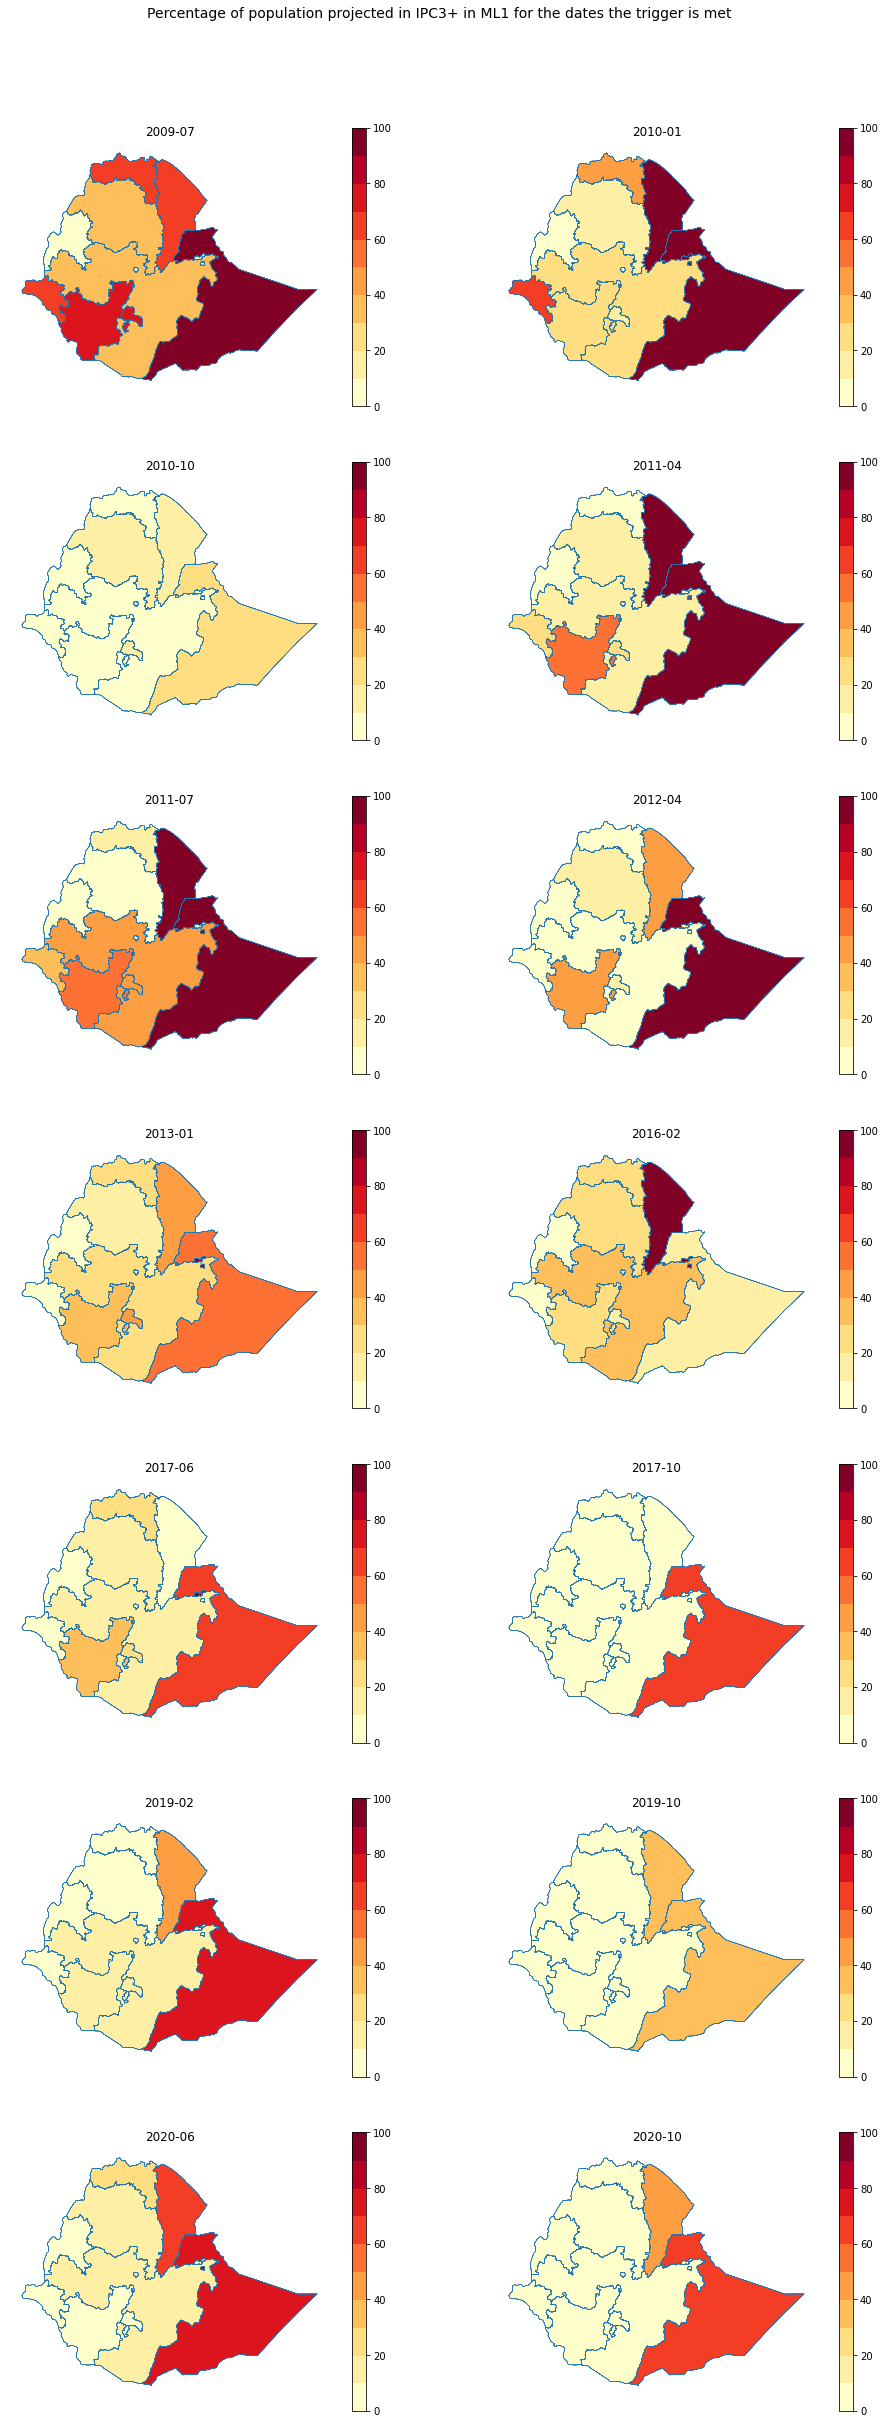

In [22]:
fig_trig_pml13p=plot_geo_var(df_fadm_trig, 
                "date",
               "perc_ML1_3p",
               title="Percentage of population projected in IPC3+ in ML1 for the dates the trigger is met",
               predef_bins=bins)

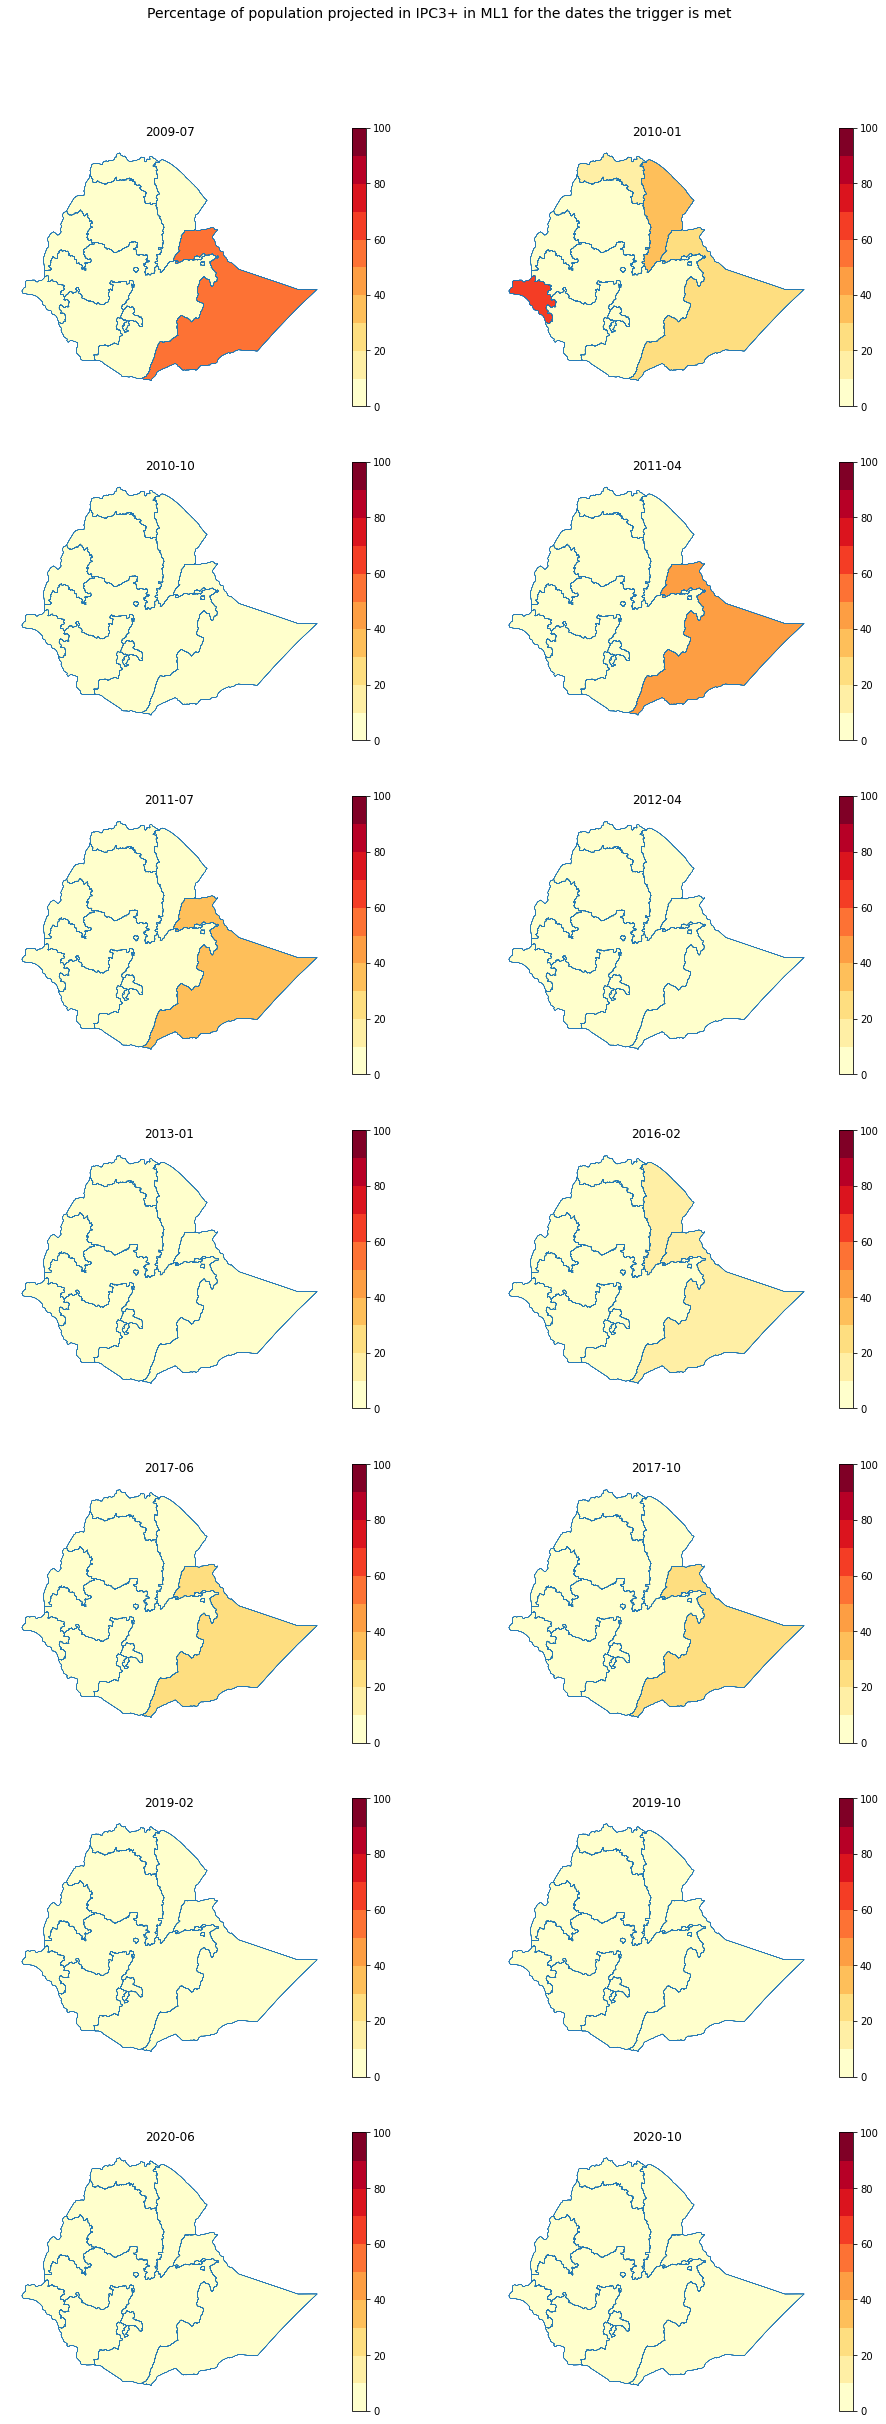

In [23]:
fig_trig_pml13p=plot_geo_var(df_fadm_trig, 
                "date",
               "perc_ML1_4p",
               title="Percentage of population projected in IPC3+ in ML1 for the dates the trigger is met",
                predef_bins=bins
               )

#### Trigger analysis Global IPC data
One of the goals was to compare the two sources of IPC data. Below are the results on the Global IPC data with the final chosen trigger

In [24]:
globalipc_dir=os.path.join(country_folder,config.DATA_DIR, config.GLOBALIPC_PROCESSED_DIR)
globalipc_path=os.path.join(globalipc_dir,f"{country}_globalipc_admin{admin_level}{suffix}.csv")

In [25]:
df_gadm=pd.read_csv(globalipc_path)

In [51]:
df_gadm["date"]=pd.to_datetime(df_fadmt["date"])
df_gadm["year"]=df_gadm["date"].dt.year
df_gadm["month"]=df_gadm["date"].dt.month

In [26]:
glob_adm1c="ADMIN1"

In [27]:
df_gadm.head(n=3)

,Unnamed: 0,date,ADMIN0,ADMIN1,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,perc_ML1_2m,perc_ML2_4p,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p,pop_CS,pop_ML1,pop_ML2,year,month
0,0,2019-09-01,ethiopia,Afar,620156.0,520182.0,313633.0,59577.0,0.0,472814.0,...,68.488016,2.905816,77.792949,-2.450905,6.854028,1513548.0,1513548.0,1536539.0,2019,9
1,1,2020-08-01,ethiopia,Afar,647322.0,516581.0,313370.0,63280.0,0.0,607531.0,...,77.329324,5.000022,67.764695,7.786292,-1.778337,1540553.0,1540554.0,1565473.0,2020,8
2,2,2020-10-01,ethiopia,Afar,284764.0,508794.0,565628.0,188142.0,0.0,320917.0,...,50.175158,NaN,NaN,NaN,1.110543,1547328.0,1575439.0,0.0,2020,10


In [28]:
df_gadm=df_gadm.replace(0,np.nan)

In [29]:
#get yes/no for different thresholds, i.e. column value for row will be 1 if threshold is met and 0 if it isnt
df_gadm["trigger_ML1_4_20"]=df_gadm.apply(lambda x: define_trigger_percentage(x,"ML1",4,20),axis=1)
df_gadm["trigger_ML1_3_30"]=df_gadm.apply(lambda x: define_trigger_percentage(x,"ML1",3,30),axis=1)
df_gadm["trigger_ML1_3_5i"]=df_gadm.apply(lambda x: define_trigger_increase(x,"ML1",3,5),axis=1)
df_gadm["trigger_ML2_4_20"]=df_gadm.apply(lambda x: define_trigger_percentage(x,"ML2",4,20),axis=1)
df_gadm["trigger_ML2_3_30"]=df_gadm.apply(lambda x: define_trigger_percentage(x,"ML2",3,30),axis=1)
df_gadm["trigger_ML2_3_5i"]=df_gadm.apply(lambda x: define_trigger_increase(x,"ML2",3,5),axis=1)

In [30]:
#initialize dict with all the analyses
dict_gan={}

In [31]:
#currently (Oct 2020) selected trigger
df_gan1=df_gadm.loc[(df_gadm["trigger_ML1_4_20"]==1) | ((df_gadm["trigger_ML1_3_30"]==1) & (df_gadm["trigger_ML1_3_5i"]==1))]
display(df_gan1.groupby(['year', 'month'], as_index=False)[glob_adm1c,'perc_ML1_4','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_gan["an1"]={"df":df_gan1,"trig_cols":["ML1_3p","CS_3p","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)"}

,year,month,ADMIN1,perc_ML1_4,perc_CS_3p,perc_ML1_3p
0,2019,9,[Afar],[6.925647551316509],[24.65795600800239],[31.511983762655692]
1,2020,10,[Somali],[9.940686642875734],[23.675666918470263],[36.31504985119348]


In [32]:
#Analysis 2: At least 20% of ADMIN1 population at IPC4+ in ML1
df_gan2 = df_gadm.loc[(df_gadm["trigger_ML1_4_20"]==1)]
display(df_gan2.groupby(['year', 'month'], as_index=False)[glob_adm1c,'perc_ML1_4'].agg(lambda x: list(x)))
dict_gan["an2"]={"df":df_gan2,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1"}

""


In [33]:
#Analysis 3: At least 30% of ADMIN1 population projected to be at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
df_gan3 = df_gadm.loc[(df_gadm["trigger_ML1_3_30"]==1) & (df_gadm["trigger_ML1_3_5i"]==1)]
display(df_gan3.groupby(['year', 'month'], as_index=False)[glob_adm1c,'perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_gan["an3"]={"df":df_gan3,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

,year,month,ADMIN1,perc_CS_3p,perc_ML1_3p
0,2019,9,[Afar],[24.65795600800239],[31.511983762655692]
1,2020,10,[Somali],[23.675666918470263],[36.31504985119348]


In [34]:
#Analysis 11: At least 20% of population projected in ML2 in IPC4+ OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)
df_gan11=df_gadm.loc[(df_gadm["trigger_ML2_4_20"]==1) | ((df_gadm["trigger_ML2_3_30"]==1)&(df_gadm["trigger_ML2_3_5i"]==1))]
display(df_gan11.groupby(['year', 'month'], as_index=False)[glob_adm1c,'perc_ML2_4','perc_CS_3p','perc_ML2_3p','perc_inc_ML2_3p','pop_CS','pop_ML2'].agg(lambda x: list(x)))
dict_gan["an11"]={"df":df_gan11,"trig_cols":["ML2_3","ML2_4"],"desc":"20% in ML2 in IPC4 OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)"}

,year,month,ADMIN1,perc_ML2_4,perc_CS_3p,perc_ML2_3p,perc_inc_ML2_3p,pop_CS,pop_ML2
0,2019,9,[Oromia],[11.111963646378882],[30.62823311279797],[35.544783265098744],[4.916550152300771],[11497627.0],[11716687.0]
1,2020,8,"[Afar, Oromia, Somali]","[5.000022357460012, 5.483458782585216, 9.97031...","[24.44901278956323, 22.614725391806324, 27.212...","[32.235305240013716, 30.487049252930767, 35.98...","[7.7862924504504925, 7.872323861124432, 8.7764...","[1540553.0, 16937641.0, 5307059.0]","[1565473.0, 17302747.0, 5444404.0]"


In [35]:
for k in dict_gan.keys():
    d=dict_gan[k]["desc"]
    num_k=k.replace("an","")
    print(f"Analysis {num_k}: GlobalIPC, {d}")
    df=dict_gan[k]["df"]
    df_grouped=df.groupby(['year', 'month'], as_index=False)[glob_adm1c].agg(lambda x: list(x))
    if df_grouped.empty:
        display(df_grouped)
    else:
        df_grouped[glob_adm1c]=[', '.join(map(str, l)) for l in df_grouped[glob_adm1c]]
        df_grouped["Trigger description"]=d
        df_grouped=df_grouped.rename(columns={glob_adm1c:"Regions triggered"})
        df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
        display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))
        b=df_grouped[["year","month","Regions triggered","Trigger description"]].set_index(['Trigger description','year', 'month'])

Analysis 1: GlobalIPC, At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)


,,Regions triggered
year,month,
2019,9,Afar
2020,10,Somali


Analysis 2: GlobalIPC, At least 20% of ADMIN1 population in IPC4+ at ML1


""


Analysis 3: GlobalIPC, At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months


,,Regions triggered
year,month,
2019,9,Afar
2020,10,Somali


Analysis 11: GlobalIPC, 20% in ML2 in IPC4 OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)


,,Regions triggered
year,month,
2019,9,Oromia
2020,8,"Afar, Oromia, Somali"


### FewsNet analysis Admin2
While the previous analysis focused on admin1 level, it is also possible to design a trigger on admin2 level. 
A small exploration was done on the FewsNet data. Finally, it was decided to focus on admin1 but this is an area that could be explored further in the future. 
For now, we explored the trigger of having 1 or more, or 2 or more, admin2 regions/admin1 region projected to be in IPC4 in ML1

In [36]:
admin_level=2
fewsnet_filename = config.FEWSWORLDPOP_PROCESSED_FILENAME.format(country=country,admin_level=admin_level,suffix=suffix)
df_fadmt=pd.read_csv(os.path.join(fewsnet_dir,fewsnet_filename))
df_fadmt["date"]=pd.to_datetime(df_fadmt["date"])
df_fadmt["year"]=df_fadmt["date"].dt.year
df_fadmt["month"]=df_fadmt["date"].dt.month

In [43]:
adm2_bound_path= os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [37]:
df_fadmt

,ADMIN0,ADMIN1,ADMIN2,date,CS_1,CS_2,CS_3,CS_4,CS_99,ML1_1,...,ML2_3p,perc_ML2_3p,ML2_4p,perc_ML2_4p,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p,year,month
0,Ethiopia,Addis Ababa,Region 14,2009-07-01,5.145931e+04,0.000000,0.00000,0.0,3070314.5,5.145931e+04,...,0.000000,0.000000,0.0,0.0,5.145931e+04,100.000000,0.000000,0.000000,2009,7
1,Ethiopia,SNNP,Konta Special,2009-07-01,1.079601e+05,1060.865234,0.00000,0.0,0.0,1.079601e+05,...,54.667015,0.050144,0.0,0.0,1.089663e+05,99.949856,0.050144,0.050144,2009,7
2,Ethiopia,SNNP,Konso,2009-07-01,0.000000e+00,403.352417,302242.59375,0.0,0.0,0.000000e+00,...,301288.968750,99.551624,0.0,0.0,1.356993e+03,0.448376,-0.315101,0.133275,2009,7
3,Ethiopia,SNNP,Kembata Tibaro,2009-07-01,0.000000e+00,128.811188,793245.06250,0.0,0.0,0.000000e+00,...,0.000000,0.000000,0.0,0.0,7.933739e+05,100.000000,-99.983764,0.000000,2009,7
4,Ethiopia,SNNP,Kefa,2009-07-01,1.003962e+06,445.597229,0.00000,0.0,0.0,1.003962e+06,...,445.597229,0.044364,0.0,0.0,1.003962e+06,99.955636,0.044364,0.044364,2009,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,Ethiopia,SNNP,Kembata Tibaro,2020-10-01,4.866899e+05,615564.312500,0.00000,0.0,NaN,4.866899e+05,...,615564.312500,55.845948,0.0,0.0,4.866899e+05,44.154052,55.845948,0.000000,2020,10
3952,Ethiopia,SNNP,Konso,2020-10-01,4.175533e+03,418496.583008,0.00000,0.0,NaN,4.175533e+03,...,418496.583008,99.012111,0.0,0.0,4.175533e+03,0.987889,99.012111,0.000000,2020,10
3953,Ethiopia,SNNP,Konta Special,2020-10-01,1.500207e+05,0.000000,0.00000,0.0,NaN,1.500207e+05,...,0.000000,0.000000,0.0,0.0,1.500207e+05,100.000000,0.000000,0.000000,2020,10
3954,Ethiopia,SNNP,Gamo,2020-10-01,1.242211e+06,558392.734375,0.00000,0.0,NaN,1.242211e+06,...,558392.734375,31.011412,0.0,0.0,1.242211e+06,68.988588,31.011412,0.000000,2020,10


In [38]:
#ML1 values of all adm2 regions in all data
#not ever been or forecasted to be IPC 5
df_fadmt.value_counts("ML1_5")

ML1_5
0.0    3956
dtype: int64

In [39]:
#select admin 2 regions with projected IPC level 4 in ML1
df_fadmtp=df_fadmt[df_fadmt.perc_ML1_4p>=20]

In [40]:
df_g=df_fadmtp.groupby(["year","month","ADMIN1"], as_index=False).agg(lambda x: list(x))
df_g=df_g[["year","month","ADMIN1","ADMIN2"]]
df_g["# ADM2 regions ML1 IPC4"]=df_g["ADMIN2"].str.len()

In [41]:
print("Analysis a): 1 or more ADMIN2 regions have IPC4 >= 20% in ML1")
df_g.drop("ADMIN2",axis=1).set_index(['year', 'month',"ADMIN1"])

Analysis a): 1 or more ADMIN2 regions have IPC4 >= 20% in ML1


# ADM2 regions ML1 IPC4
year month ADMIN1                          
2009 7     Somali                         8
2010 1     Afar                           4
           Amhara                         2
           Gambela                        3
           Somali                         4
           Tigray                         2
     4     Amhara                         1
           Oromia                         1
2011 4     Somali                         6
     7     Oromia                         3
           Somali                         9
2015 10    Afar                           1
           Somali                         1
2016 2     Afar                           1
           Amhara                         1
           Oromia                         2
           Somali                         1
2017 6     Somali                         5
     10    Somali                         4

In [42]:
print("Analysis b): 2 or more ADMIN2 regions have IPC4 >= 20% in ML1")
df_g[df_g["# ADM2 regions ML1 IPC4"]>1].drop("ADMIN2",axis=1).set_index(['year', 'month',"ADMIN1"])

Analysis b): 2 or more ADMIN2 regions have IPC4 >= 20% in ML1


# ADM2 regions ML1 IPC4
year month ADMIN1                          
2009 7     Somali                         8
2010 1     Afar                           4
           Amhara                         2
           Gambela                        3
           Somali                         4
           Tigray                         2
2011 4     Somali                         6
     7     Oromia                         3
           Somali                         9
2016 2     Oromia                         2
2017 6     Somali                         5
     10    Somali                         4

In [49]:
df_fadmt["threshold_reached"]= np.where(df_fadmt.perc_ML1_4p>=20,1,0)
gdft=gpd.read_file(adm2_bound_path).rename(columns={parameters["shp_adm2c"]:config.ADMIN2_COL})
df_fadmt=gdft[["ADMIN2","geometry"]].merge(df_fadmt,how="right")

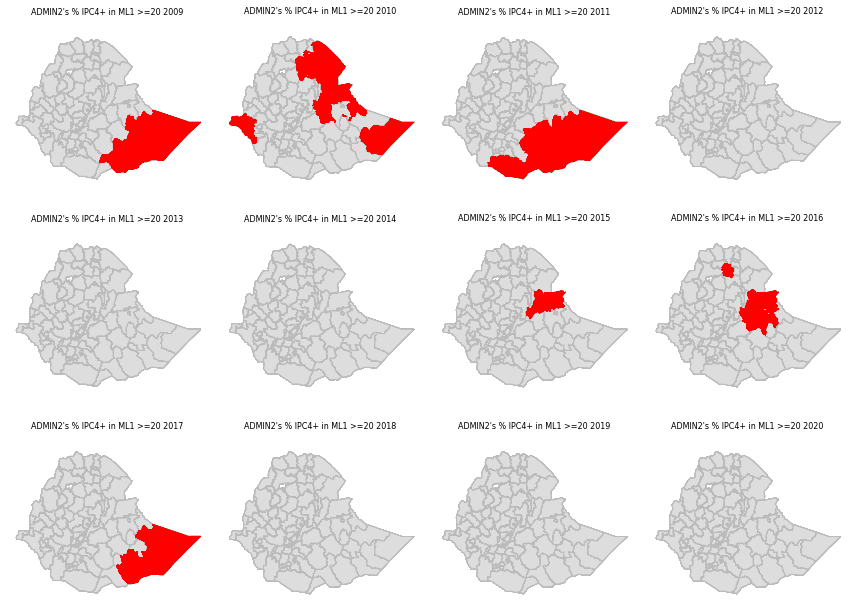

In [54]:
fig_boundbint=plot_boundaries_binary(df_fadmt,"threshold_reached",subplot_col="year",subplot_str_col="year",region_col="ADMIN2",colp_num=4,only_show_reached=False,title_str="ADMIN2's % IPC4+ in ML1 >=20",print_reg=False)

In [55]:
df_fadmt["date_str"]=df_fadmt.date.dt.strftime("%Y-%m")

In [ ]:
fig_boundbint=plot_boundaries_binary(df_fadmt,"threshold_reached",subplot_col="date",subplot_str_col="date_str",region_col="ADMIN2",colp_num=4,only_show_reached=False,title_str="ADMIN2's % IPC4+ in ML1 >=20",print_reg=False)